In [1]:
from pkg.utils.utils_python3 import *
import random
import shutil
import os

DATA_PATH = "./data"
CONVERTED_PATH = "./data/converted"
SCENE_FILENAME = "scene.pkl"
JOINT_NUM = 13
gtimer = GlobalTimer()
# ## Load Global params
DATASET_LIST = sorted(os.listdir(CONVERTED_PATH))
trainset_num = None
if trainset_num is not None:
    TRAINSET_LIST =  DATASET_LIST[:trainset_num]
    TESTSET_LIST = DATASET_LIST[trainset_num:]
else:
    TRAINSET_LIST = ['20201214-165211', '20201216-021416', '20201218-024611']
    TESTSET_LIST = ['20201208-121454', '20201212-232318', '20201213-061207']
    #TRAINSET_LIST = ['20201221-020250']
    #TESTSET_LIST = ['20201220-222433']
    
# trainset
SCENE_TUPLE_LIST = []
for DATASET in TRAINSET_LIST:
    CURRENT_PATH = os.path.join(CONVERTED_PATH, DATASET)
    #Iterate world
    WORLD_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(CURRENT_PATH)))
    gtimer.reset()
    for WORLD in WORLD_LIST:
        WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
        # Iterate scene
        SCENE_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(WORLD_PATH)))
        for SCENE in SCENE_LIST:
            SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
            ACTION_LIST = sorted(filter(lambda x: x != SCENE_FILENAME, os.listdir(SCENE_PATH)))
            for ACTION in ACTION_LIST:
                N_action = get_action_count(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION)
                for i_act in range(N_action):
                    SCENE_TUPLE_LIST.append((CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION, i_act, JOINT_NUM))
                    #gtimer.tic("load_scene_data")
                    #scene_data, success, skey = load_scene_data(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION, i_act, JOINT_NUM)
                    #gtimer.toc("load_scene_data")
train_set = SCENE_TUPLE_LIST
N_train = len(train_set)

# trainset
SCENE_TUPLE_LIST = []
for DATASET in TESTSET_LIST:
    CURRENT_PATH = os.path.join(CONVERTED_PATH, DATASET)
    #Iterate world
    WORLD_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(CURRENT_PATH)))
    gtimer.reset()
    for WORLD in WORLD_LIST:
        WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
        # Iterate scene
        SCENE_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(WORLD_PATH)))
        for SCENE in SCENE_LIST:
            SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
            ACTION_LIST = sorted(filter(lambda x: x != SCENE_FILENAME, os.listdir(SCENE_PATH)))
            for ACTION in ACTION_LIST:
                N_action = get_action_count(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION)
                for i_act in range(N_action):
                    SCENE_TUPLE_LIST.append((CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION, i_act, JOINT_NUM))
                    #gtimer.tic("load_scene_data")
                    #scene_data, success, skey = load_scene_data(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION, i_act, JOINT_NUM)
                    #gtimer.toc("load_scene_data")
test_set = SCENE_TUPLE_LIST
N_test = len(test_set)
print(f'Train/Test: {N_train}, {N_test}')

Train/Test: 57487, 18273


In [2]:
joint_num = 13
N_vtx_box = 3*8
N_mask_box = 1
N_joint_box = joint_num
N_label_box = N_vtx_box+N_mask_box+N_joint_box
N_vtx_cyl = 3*2+1
N_mask_cyl = 1
N_joint_cyl = joint_num
N_label_cyl = N_vtx_cyl+N_mask_cyl+N_joint_cyl
N_vtx_init = 3*8
N_mask_init = 1
N_joint_init = joint_num
N_label_init = N_vtx_init+N_mask_init+N_joint_init
N_vtx_goal = 3*8
N_mask_goal = 1
N_joint_goal = joint_num
N_label_goal = N_vtx_goal+N_mask_goal+N_joint_goal
N_joint_label = 6*joint_num
N_cell_label = N_label_box+N_label_cyl+N_label_init+N_label_goal + N_joint_label
N_BEGIN_CYL = N_vtx_box+N_mask_box+N_joint_box
N_BEGIN_INIT = N_BEGIN_CYL+N_vtx_cyl+N_mask_cyl+N_joint_cyl
N_BEGIN_GOAL = N_BEGIN_INIT+N_vtx_init+N_mask_init+N_joint_init
def separate_dat(scene_data):
    cbox = scene_data[:,:,:,:, :N_vtx_box]
    cbox_m = scene_data[:,:,:,:, N_vtx_box]
    cbox_j = scene_data[:,:,:,:, N_vtx_box+1:N_vtx_box+1+N_joint_box]
    ccyl = scene_data[:,:,:,:, N_BEGIN_CYL:N_BEGIN_CYL+N_vtx_cyl]
    ccyl_m = scene_data[:,:,:,:, N_BEGIN_CYL+N_vtx_cyl]
    ccyl_j = scene_data[:,:,:,:, N_BEGIN_CYL+N_vtx_cyl+1:N_BEGIN_CYL+N_vtx_cyl+1+N_joint_cyl]
    ibox = scene_data[:,:,:,:, N_BEGIN_INIT:N_BEGIN_INIT+N_vtx_box]
    ibox_m = scene_data[:,:,:,:, N_BEGIN_INIT+N_vtx_box]
    ibox_j = scene_data[:,:,:,:, N_BEGIN_INIT+N_vtx_box+1:N_BEGIN_INIT+N_vtx_box+1+N_joint_init]
    gbox = scene_data[:,:,:,:, N_BEGIN_GOAL:N_BEGIN_GOAL+N_vtx_box]
    gbox_m = scene_data[:,:,:,:, N_BEGIN_GOAL+N_vtx_box]
    gbox_j = scene_data[:,:,:,:, N_BEGIN_GOAL+N_vtx_box+1:N_BEGIN_GOAL+N_vtx_box+1+N_joint_goal]
    joints = scene_data[:,:,:,:,-N_joint_label:]
    joints = np.reshape(joints, scene_data.shape[:4]+(-1,6))
    cbox = np.concatenate([cbox, 
                           (joints*np.expand_dims(cbox_j, axis=-1)).reshape(scene_data.shape[:4]+(-1,))], 
                          axis=-1)
    ccyl = np.concatenate([ccyl, 
                           (joints*np.expand_dims(ccyl_j, axis=-1)).reshape(scene_data.shape[:4]+(-1,))], 
                          axis=-1)
    ibox = np.concatenate([ibox, 
                           (joints*np.expand_dims(ibox_j, axis=-1)).reshape(scene_data.shape[:4]+(-1,))], 
                          axis=-1)
    gbox = np.concatenate([gbox, 
                           (joints*np.expand_dims(gbox_j, axis=-1)).reshape(scene_data.shape[:4]+(-1,))], 
                          axis=-1)
    return (cbox, np.expand_dims(cbox_m, axis=-1), 
            ccyl, np.expand_dims(ccyl_m, axis=-1), 
            ibox, np.expand_dims(ibox_m, axis=-1), 
            gbox, np.expand_dims(gbox_m, axis=-1))

In [3]:
import tensorflow as tf

from tensorflow.keras import layers as KL
from tensorflow.keras import Model
import datetime

class DenseBN(KL.Layer):
    def __init__(self, units, name, use_bias=False, activation="relu"):
        super(DenseBN, self).__init__()
        self.dense = KL.Dense(units, name='dense_' + name, use_bias=use_bias)
        self.bn = KL.BatchNormalization(name='bn_' + name)
        self.ac = KL.Activation(activation)
        
    def call(self, x, training=False):
        x = self.dense(x)
        x = self.bn(x, training=training)
        x = self.ac(x)
        return x
        

class IdentityBlock(KL.Layer):
    def __init__(self, kernel_size, filters, stage, block,
                 use_bias=False, use_bn=True, ConvLayer=KL.Conv2D):
        super(IdentityBlock, self).__init__()
        self.use_bn = use_bn
        nb_filter1, nb_filter2, nb_filter3 = filters
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        
        self.conv1 = ConvLayer(nb_filter1, 1, name=conv_name_base + '2a',
                               use_bias=use_bias)
        if self.use_bn:
            self.bn1 = KL.BatchNormalization(name=bn_name_base + '2a')
        self.ac1 = KL.Activation('relu')
        
        self.conv2 = ConvLayer(nb_filter2, kernel_size, padding="same",
                               name=conv_name_base + '2b', use_bias=use_bias)
        if self.use_bn:
            self.bn2 = KL.BatchNormalization(name=bn_name_base + '2b')
        self.ac2 = KL.Activation('relu')
        
        self.conv3 = ConvLayer(nb_filter3, 1, name=conv_name_base + '2c',
                               use_bias=use_bias)
        if self.use_bn:
            self.bn3 = KL.BatchNormalization(name=bn_name_base + '2c')
        self.add = KL.Add()
        self.ac3 = KL.Activation('relu', name='res' + str(stage) + block + '_out')
        
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        if self.use_bn:
            x = self.bn1(x, training=training)
        x = self.ac1(x)

        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x, training=training)
        x = self.ac2(x)

        x = self.conv3(x)
        if self.use_bn:
            x = self.bn3(x, training=training)

        x = self.add([x, input_tensor])
        x = self.ac3(x)
        return x
    
class IdentityBlock3D(IdentityBlock):
    def __init__(self, *args, **kwargs):
        super(IdentityBlock3D, self).__init__(*args, ConvLayer=KL.Conv3D, **kwargs)
    
    

class ConvBlock(KL.Layer):
    def __init__(self, kernel_size, filters, stage, block, strides=2,
                 use_bias=False, use_bn=True, ConvLayer=KL.Conv2D):
        super(ConvBlock, self).__init__()
        self.use_bn = use_bn
        nb_filter1, nb_filter2, nb_filter3 = filters
        conv_name_base = 'res' + str(stage) + block + '_branch'
        bn_name_base = 'bn' + str(stage) + block + '_branch'
        
        self.conv1 = ConvLayer(nb_filter1, 1, strides=strides, 
                               name=conv_name_base + '2a', use_bias=use_bias)
        if self.use_bn:
            self.bn1 = KL.BatchNormalization(name=bn_name_base + '2a')
        self.ac1 = KL.Activation('relu')
        
        self.conv2 = ConvLayer(nb_filter2, kernel_size, padding="same",
                               name=conv_name_base + '2b', use_bias=use_bias)
        if self.use_bn:
            self.bn2 = KL.BatchNormalization(name=bn_name_base + '2b')
        self.ac2 = KL.Activation('relu')
        
        self.conv3 = ConvLayer(nb_filter3, 1, name=conv_name_base + '2c',
                               use_bias=use_bias)
        if self.use_bn:
            self.bn3 = KL.BatchNormalization(name=bn_name_base + '2c')

        self.convs = ConvLayer(nb_filter3, 1, strides=strides,
                               name=conv_name_base + '1', use_bias=use_bias)
        if self.use_bn:
            self.bns = KL.BatchNormalization(name=bn_name_base + '1')
    
        self.add = KL.Add()
        self.ac3 = KL.Activation('relu', name='res' + str(stage) + block + '_out')
        
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        if self.use_bn:
            x = self.bn1(x, training=training)
        x = self.ac1(x)

        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x, training=training)
        x = self.ac2(x)

        x = self.conv3(x)
        if self.use_bn:
            x = self.bn3(x, training=training)
        
        shortcut = self.convs(input_tensor)
        if self.use_bn:
            shortcut = self.bns(shortcut, training=training)

        x = self.add([x, shortcut])
        x = self.ac3(x)
        return x
    
class ConvBlock3D(ConvBlock):
    def __init__(self, *args, **kwargs):
        super(ConvBlock3D, self).__init__(*args, ConvLayer=KL.Conv3D, **kwargs)
    

class ResNet(KL.Layer):
    def __init__(self, architecture="resnet50", stage0=None, stage1=None, stage2=[64, 64, 256], stage3=[128, 128, 512], 
                 stage4=[256, 256, 1024], stage5=None, 
                 ConvLayer=KL.Conv2D, ZeroPadding=KL.ZeroPadding2D, MaxPool=KL.MaxPooling2D, 
                 ConvBlock=ConvBlock, IdentityBlock=IdentityBlock, input_size=(15,15,15), joint_num=13, batch_size=16):
        super(ResNet, self).__init__()
        """Build a ResNet graph.
            architecture: Can be resnet50 or resnet101
            stage5: recommanded default values = [512, 512, 2048]. If None, stage5 of the network is not created
        """
        assert architecture in ["resnet50", "resnet101"]
        self.stage1 = stage1 is not None
        self.stage5 = stage5 is not None
        self.stage0 = stage0 is not None
        self.input_size = input_size
        self.joint_num = joint_num
        self.batch_size = batch_size
        if self.stage0:
            self.pre_boxa = ConvBlock(1, stage0, stage=0, block='ba', strides=1, use_bias=True, use_bn=False)
            self.pre_boxb = IdentityBlock(1, stage0, stage=0, block='bb')
            self.pre_boxc = IdentityBlock(1, stage0, stage=0, block='bc')
            self.pre_cyla = ConvBlock(1, stage0, stage=0, block='ca', strides=1, use_bias=True, use_bn=False)
            self.pre_cylb = IdentityBlock(1, stage0, stage=0, block='cb')
            self.pre_cylc = IdentityBlock(1, stage0, stage=0, block='cc')
            self.pre_inia = ConvBlock(1, stage0, stage=0, block='ia', strides=1, use_bias=True, use_bn=False)
            self.pre_inib = IdentityBlock(1, stage0, stage=0, block='ib')
            self.pre_inic = IdentityBlock(1, stage0, stage=0, block='ic')
            self.pre_gola = ConvBlock(1, stage0, stage=0, block='ga', strides=1, use_bias=True, use_bn=False)
            self.pre_golb = IdentityBlock(1, stage0, stage=0, block='gb')
            self.pre_golc = IdentityBlock(1, stage0, stage=0, block='gc')
            self.concat = KL.Concatenate()
        
        if self.stage1:
            # Stage 1  output size = 1/1
            self.cb1a = ConvBlock(3, stage1, stage=1, block='a', strides=1)
            self.ib1b = IdentityBlock(3, stage1, stage=1, block='b')
            self.ib1c = IdentityBlock(3, stage1, stage=1, block='c')
            stride_2 = 2
        else:
            # Stage 1 original output size = 1/4
            self.cv1 = ConvLayer(64, 7, strides=2, 
                                 name='conv1', padding="same", use_bias=False)
            self.bn1 = KL.BatchNormalization(name='bn_conv1')
            self.ac1 = KL.Activation('relu')
            self.mp1 = MaxPool(3, strides=2, padding="same")
            stride_2 = 1
        
        # Stage 2  output size = 1/stride_2
        self.cb2a = ConvBlock(3, stage2, stage=2, block='a', strides=stride_2)
        self.ib2b = IdentityBlock(3, stage2, stage=2, block='b')
        self.ib2c = IdentityBlock(3, stage2, stage=2, block='c')
        
        # Stage 3  output size = 1/2
        self.cb3a = ConvBlock(3, stage3, stage=3, block='a')
        self.ib3b = IdentityBlock(3, stage3, stage=3, block='b')
        self.ib3c = IdentityBlock(3, stage3, stage=3, block='c')
        self.ib3d = IdentityBlock(3, stage3, stage=3, block='d')
        
        # Stage 4  output size = 1/2
        self.cb4a = ConvBlock(3, stage4, stage=4, block='a')
        block_count = {"resnet50": 5, "resnet101": 22}[architecture]
        self.ib4_list = []
        for i in range(block_count):
            self.ib4_list.append(
                IdentityBlock(3, stage4, stage=4, block=chr(98 + i))
            )
            
        # Stage 5  output size = 1/2
        if self.stage5:
            self.cb5a = ConvBlock(3, stage5, stage=5, block='a')
            self.ib5b = IdentityBlock(3, stage5, stage=5, block='b')
            self.ib5c = IdentityBlock(3, stage5, stage=5, block='c')

    def call(self, input_image, training=False):
        if self.stage0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = input_image
            cbox = self.pre_boxa(cbox, training=training)
            cbox = self.pre_boxb(cbox, training=training)
            cbox = self.pre_boxc(cbox, training=training)*cbox_m
            ccyl = self.pre_cyla(ccyl, training=training)
            ccyl = self.pre_cylb(ccyl, training=training)
            ccyl = self.pre_cylc(ccyl, training=training)*ccyl_m
            ibox = self.pre_inia(ibox, training=training)
            ibox = self.pre_inib(ibox, training=training)
            ibox = self.pre_inic(ibox, training=training)*ibox_m
            gbox = self.pre_gola(gbox, training=training)
            gbox = self.pre_golb(gbox, training=training)
            gbox = self.pre_golc(gbox, training=training)*gbox_m
            x = self.concat([cbox, ccyl, ibox, gbox])
        else:
            x = input_image
        # Stage 1
        if self.stage1:
            x = self.cb1a(x, training=training)
            x = self.ib1b(x, training=training)
            C1 = x = self.ib1c(x, training=training)
        else:
            x = self.cv1(x)
            x = self.bn1(x, training=training)
            x = self.ac1(x)
            C1 = x = self.mp1(x)
        
        # Stage 2
        x = self.cb2a(x, training=training)
        x = self.ib2b(x, training=training)
        C2 = x = self.ib2c(x, training=training)
        
        # Stage 3
        x = self.cb3a(x, training=training)
        x = self.ib3b(x, training=training)
        x = self.ib3c(x, training=training)
        C3 = x = self.ib3d(x, training=training)
        
        # Stage 4
        x = self.cb4a(x, training=training)
        for ib4 in self.ib4_list:
            x = ib4(x, training=training)
        C4 = x
            
        # Stage 5
        if self.stage5:
            x = self.cb5a(x, training=training)
            x = self.ib5b(x, training=training)
            C5 = x = self.ib5c(x, training=training)
            return [C1, C2, C3, C4, C5]
        else:
            return [C1, C2, C3, C4]
            
    

In [4]:
class ResNetModelTP(Model):
    def __init__(self, 
                 ConvLayer=KL.Conv3D, ZeroPadding=KL.ZeroPadding3D, MaxPool=KL.GlobalMaxPool3D, 
                 ConvBlock=ConvBlock3D, IdentityBlock=IdentityBlock3D):
        super(ResNetModelTP, self).__init__()
        self.resnet = ResNet(architecture="resnet50", 
                             stage0 = [64,64,32], stage1=[64, 64, 64], 
                             stage2=[64, 64, 64], stage3=[64, 64, 64], 
                             stage4=[64, 64, 64], stage5=[64, 64, 64], 
                             ConvLayer=ConvLayer, ZeroPadding=ZeroPadding, MaxPool=MaxPool, 
                             ConvBlock=ConvBlock, IdentityBlock=IdentityBlock)
        dense_depth1, dense_depth2= 128, 64
        self.gp1 = MaxPool()
        self.gp2 = MaxPool()
        self.gp3 = MaxPool()
        self.gp4 = MaxPool()
        self.gp5 = MaxPool()
        self.dens11 = DenseBN(dense_depth1, "dens11")
        self.dens21 = DenseBN(dense_depth1, "dens21")
        self.dens31 = DenseBN(dense_depth1, "dens31")
        self.dens41 = DenseBN(dense_depth1, "dens41")
        self.dens51 = DenseBN(dense_depth1, "dens51")
        self.dropout11 = KL.Dropout(0.1)
        self.dropout21 = KL.Dropout(0.1)
        self.dropout31 = KL.Dropout(0.1)
        self.dropout41 = KL.Dropout(0.1)
        self.dropout51 = KL.Dropout(0.1)
        self.dens12 = KL.Dense(dense_depth2) # DenseBN(512, "dens1")
        self.dens22 = KL.Dense(dense_depth2) # DenseBN(512, "dens2")
        self.dens32 = KL.Dense(dense_depth2) # DenseBN(512, "dens3")
        self.dens42 = KL.Dense(dense_depth2) # DenseBN(512, "dens4")
        self.dens52 = KL.Dense(dense_depth2) # DenseBN(512, "dens5")
        self.dropout12 = KL.Dropout(0.1)
        self.dropout22 = KL.Dropout(0.1)
        self.dropout32 = KL.Dropout(0.1)
        self.dropout42 = KL.Dropout(0.1)
        self.dropout52 = KL.Dropout(0.1)
        self.concat = KL.Concatenate()
        self.dens_int1 = DenseBN(dense_depth1, "dens_int1")
        self.dropout1 = KL.Dropout(0.1)
        self.dens_int2 = DenseBN(dense_depth2, "dens_int2")
        self.dropout2 = KL.Dropout(0.1)
        self.dens_out = KL.Dense(2)

    def call(self, x, training=False):
        C1, C2, C3, C4, C5 = self.resnet(x, training=training)
        f1 = self.dens11(self.gp1(C1), training=training)
        f1 = self.dropout11(f1)
        f1 = self.dens12(f1, training=training)
        f1 = self.dropout12(f1)
        f2 = self.dens21(self.gp2(C2), training=training)
        f2 = self.dropout21(f2)
        f2 = self.dens22(f2, training=training)
        f2 = self.dropout22(f2)
        f3 = self.dens31(self.gp3(C3), training=training)
        f3 = self.dropout31(f3)
        f3 = self.dens32(f3, training=training)
        f3 = self.dropout32(f3)
        f4 = self.dens41(self.gp4(C4), training=training)
        f4 = self.dropout41(f4)
        f4 = self.dens42(f4, training=training)
        f4 = self.dropout42(f4)
        f5 = self.dens51(self.gp5(C5), training=training)
        f5 = self.dropout51(f5)
        f5 = self.dens52(f5, training=training)
        f5 = self.dropout52(f5)
        x = self.concat([f1,f2,f3,f4,f5])
        # x = f5
        x = self.dens_int1(x, training=training)
        x = self.dropout1(x, training=training)
        x = self.dens_int2(x, training=training)
        x = self.dropout2(x, training=training)
        x = self.dens_out(x)
        return x

# # Create an instance of the model
# model = ResNetModelTP()

In [5]:
def get_action_type(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION, idx_act, joint_num):
    action_data_dict = load_json(os.path.join(DATA_PATH, DATASET, WORLD, SCENE, ACTION.replace(".pkl", ".json")))
    if action_data_dict[str(idx_act)]['rname1'] and action_data_dict[str(idx_act)]['rname2']:
        atype = "handover"
    elif action_data_dict[str(idx_act)]['obj1']['collision']:
        atype = "place"
    elif action_data_dict[str(idx_act)]['obj2']['collision']:
        atype = "pick"
    else:
        raise(RuntimeError("Unexpected case"))
    return atype

In [6]:
import tensorflow as tf
    
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [7]:
MODEL_NAME = "20201223-182351"
logpath = os.path.join('logs','gradient_tape',MODEL_NAME)
model_log_dir = os.path.join(logpath, 'model.h5/')
model = tf.keras.models.load_model(model_log_dir)

In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [9]:
BATCH_SIZE = 100
LOG_STEP = 100

## All cases

In [10]:
test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    i_step += 1
    scene_batch.append(scene_data)
    success_batch.append(success)
    if i_step%BATCH_SIZE==0:
        cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
        test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
        scene_batch, success_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Full Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if success:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Success Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if not success:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Failure Accuracy ({i_step}): {test_accuracy.result() * 100}')

Full Accuracy (18273): 77.61724853515625
Success Accuracy (6361): 70.8536376953125
Failure Accuracy (11912): 81.22901153564453


## Pick cases

In [11]:
action_target = "pick"

test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Full Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Success Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if not success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Failure Accuracy ({i_step}): {test_accuracy.result() * 100}')

Full Accuracy (5459): 78.38432312011719
Success Accuracy (1794): 75.2508316040039
Failure Accuracy (3665): 79.91814422607422


## Place cases

In [12]:
action_target = "place"

test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Full Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Success Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if not success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Failure Accuracy ({i_step}): {test_accuracy.result() * 100}')

Full Accuracy (4248): 75.56497192382812
Success Accuracy (1338): 67.4887924194336
Failure Accuracy (2910): 79.27835083007812


## handover cases

In [13]:
action_target = "handover"

test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Full Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Success Accuracy ({i_step}): {test_accuracy.result() * 100}')


test_accuracy.reset_states()


i_step = 0
scene_batch, success_batch = [], []
for scene_tuple in test_set:
    scene_data, success, skey = load_scene_data(*scene_tuple)
    if not success and get_action_type(*scene_tuple)==action_target:
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%BATCH_SIZE==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
if i_step%BATCH_SIZE!=0 and len(scene_batch)>0:
    cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
    test_step([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))


print(f'Failure Accuracy ({i_step}): {test_accuracy.result() * 100}')

Full Accuracy (8566): 78.14615631103516
Success Accuracy (3229): 69.80489349365234
Failure Accuracy (5337): 83.19281005859375


## Test times

In [10]:
from collections import defaultdict

In [20]:
batch_sizes = [4, 8, 12, 16, 24, 32, 64]

gtimer.reset()
for batch_size in batch_sizes:
    @tf.function
    def test_step_tmp(images, labels):
        predictions = model(images, training=False)
        return predictions

    i_step = 0
    scene_batch, success_batch = [], []
    batch_count = 0
    batch_count_max = 50
    for scene_tuple in test_set:
        scene_data, success, skey = load_scene_data(*scene_tuple)
        i_step += 1
        scene_batch.append(scene_data)
        success_batch.append(success)
        if i_step%batch_size==0:
            cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m = separate_dat(np.array(scene_batch, dtype=np.float32))
            if batch_count == 0:
                test_step_tmp([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            batch_count += 1
            gtimer.tic(str(batch_size))
            test_step_tmp([cbox, cbox_m, ccyl, ccyl_m, ibox, ibox_m, gbox, gbox_m], np.array(success_batch,dtype=np.int))
            gtimer.toc(str(batch_size), stack=True)
            if batch_count >= batch_count_max:
                break
            scene_batch, success_batch = [], []
        if i_step%LOG_STEP==0:
                print("test step - {}/{}        ".format(i_step, N_test), end = '\r')


    print(f'mean time ({batch_size}): {gtimer.time_dict[str(batch_size)] / gtimer.count_dict[str(batch_size)]/batch_size}')

mean time (4): 1.9545817375183105
mean time (8): 1.489320993423462
mean time (12): 1.1586602528889973
mean time (16): 1.0937497019767761
mean time (24): 1.1309679349263508
mean time (32): 2.2144901752471924
mean time (64): 2.1771758049726486


In [44]:
mean_times = []
min_times = []
max_times = []
std_times = []
batch_sizes_plot = batch_sizes[:-1]
for batch_size in batch_sizes_plot:
    timelist = gtimer.timelist_dict[str(batch_size)]
    mean_times.append(np.mean(timelist)/batch_size)
    min_times.append(np.min(timelist)/batch_size)
    max_times.append(np.max(timelist)/batch_size)
    std_times.append(np.std(timelist)/batch_size)

In [45]:
import matplotlib.pyplot as plt

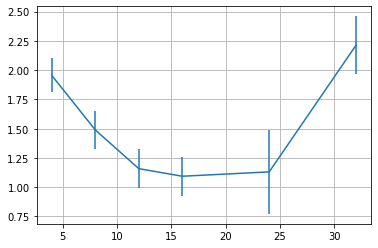

In [51]:
plt.errorbar(batch_sizes_plot, mean_times, std_times)
plt.grid()

In [55]:
batch_sizes_plot

[4, 8, 12, 16, 24, 32]

In [52]:
mean_times

[1.9545817375183105,
 1.489320993423462,
 1.1586602528889973,
 1.0937497019767761,
 1.1309679349263508,
 2.2144901752471924]

In [53]:
std_times

[0.14556603107133567,
 0.16431240084168167,
 0.16748516524169613,
 0.16637990088824536,
 0.359041183473676,
 0.24575944730035537]